# 3. Paraméterbecslés valószínűségi modellekben Tensorflow-val



In [ ]:
!pip install daft

In [1]:
import daft
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import tensorflow as tf
%matplotlib inline

/Users/karaj/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 3.1 Lineáris-Gauss modellek

Ezekben a modellekben mindig egy megfigyelt ($x$) és egy rejtett ($u$) változó van, az előbbi Gauss eloszlású az utóbbira kondicionálva, és a mean paramétere a rejtett változó lineáris keveréséből áll elő.

$$p(x \mid u) = \mathcal{N}(A u, C_x) $$
$$ x \in \mathbb{R}^{d_x},\; u \in \mathbb{R}^{d_u},\; A \in \mathbb{R}^{d_x \times d_u},\; C_x \in \mathbb{R}^{d_x \times d_x}$$

Ez értelmezhező úgy, hogy az $A$ mátrix oszlopai az alapelemek vagy bázisok, amikből lineárisan összeadódik a megfigyelés, hiszen $x = \sum_{i=1}^{d_u} u_i A_{\cdot i} + \xi$, ahol $\xi \sim \mathcal{N}(0,C_x)$. A rejtett változó prior eloszlása és az $A$ és $C_x$ mátrixokra vonatkozó megkötések különbözőképpen választhatóak, az így előálló modellekről lásd az alábbi összefoglalást:

Roweis, S., & Ghahramani, Z. (1999). [A unifying review of linear Gaussian models](https://authors.library.caltech.edu/13697/1/ROWnc99.pdf). Neural computation, 11(2), 305-345.

Mi először vegyük azt a verziót, ahol $C_x = \sigma_x I,\; \sigma_x \in \mathbb{R}$ és $p(u) = \mathcal{N}(0,\sigma_u I)$.

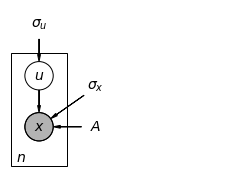

In [2]:
rc("font", family="serif", size=14)
pgm = daft.PGM((4, 2.8), origin=(0.15, 0.15))
pgm.add_node(daft.Node("x", r"$x$", 0.65, 0.9, observed=True))
pgm.add_node(daft.Node("A", r"$A$", 1.65, 0.9, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("sigma", r"$\sigma_x$", 1.65, 1.6, observed=False, plot_params={"ec": "none"}))
pgm.add_node(daft.Node("u", r"$u$", 0.65, 1.8, observed=False))
pgm.add_node(daft.Node("prior_param", r"$\sigma_u$", 0.65, 2.7, observed=False, plot_params={"ec": "none"}))
pgm.add_plate(daft.Plate([0.15, 0.2, 1., 2],label=r"$n$"))
pgm.add_edge("u","x")
pgm.add_edge("A","x")
pgm.add_edge("sigma","x")
pgm.add_edge("prior_param","u")
pgm.render()

A modellel az lesz a célunk, hogy olyan értékeket keressünk az $A$ mátrix oszlopainak, amik jól leírják azokat a komponenseket, amelyekből a megfigyeléseink összeállíthatók (a modell többi paraméterét most konstansnak fogjuk tekinteni). Ez azt jelenti, hogy olyan paraméterértékeket keresünk amelyekkel modellünk minél nagyobb likelihoodot rendel a megfigyelésekhez ($X = \lbrace x_1 \dots x_n \rbrace$):

$$A^\star = \mathrm{argmax} \; p(X \mid A) = \mathrm{argmax} \; \log p(X \mid A)$$

Mivel a logaritmus monoton függvény, az `argmax` eredményét nem változtatja meg. A likelihood a plate definíciója szerint faktorizálódik, és általában a rejtett változó poszterior eloszlásának kiintegrálását tartalmazza. Ezt az integrált közelíthetjük úgy, hogy a poszterior eloszlást csak egy ponton értékeljük ki, ott ahol a legmagasabb az értéke, a rejtett változó maximum a posteriori (MAP) becslésénél, ami a mi modellünkben egyszerűen számolható (az egyszerűség kedvéért feltéve, hogy $\sigma_x = \sigma_u = 1$, számolásokhoz segítségül hívható a [Matrix Cookbook](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf)):

$$p(X \mid A) = \prod_{i=1}^n p(x_i \mid A) = \prod_{i=1}^n \int_{-\infty}^{\infty} p(x_i \mid A, u_i) p(u_i \mid x_i,A) \mathrm{d}u_i \approx \prod_{i=1}^n p(x_i \mid A,u_i^{MAP})$$

$$ u_i^{MAP} = \mathrm{argmax} \; p(u_i \mid x_i,A) = x_iA^T $$

A likelihoodfüggvény közelítésének maximumát kereshetjük a szélsőértékkeresésre általánosan használt gradiens-módszerrel, ahol az $A$ mátrix elemeit véletlen értékekre állítjuk, majd iteratívan változtatjuk az alábbi formula szerint:

$$\Delta A = \varepsilon \frac{\partial}{\partial A}\log p(X \mid A) \approx \varepsilon \frac{\partial}{\partial A} \sum_{i=1}^n \log p(x_i \mid A,u_i^{MAP})$$

## 3.2 Paraméterbecslési probléma definíciója Tensorflow-ban

Sok mátrixszorzást tartalmazó szélsőértékkeresési problémákra jól használható az elsősorban deep learning céljaira kifejlesztett Tensorflow. Nagy előnye, hogy ha megadjuk a minimalizálandó költségfüggvényt, a differenciálást és az iteratív lépkedést automatikusan elvégzi (lásd még itt: [https://www.tensorflow.org/tutorials/](https://www.tensorflow.org/tutorials/)).

Megmutatható, hogy Gauss prior eloszlás mellett az imént bevezetett log-likelihood maximuma megegyezik a tényleges stimulus, $x$, és a rejtett változóra vonatkozó pontbecslés segítségével a bázisokból rekonstruált stimulus, $u^{MAP} A$ négyzetes különbségének minimumával. Ezt a mennyiséget kell tehát minimalizálnunk a Tensorflow segítségével. 

A megfigyelt változókat és hiperparamétereket a `placeholder` függvény segítségével hozhatjuk létre (aminek hasonló a szerepe a Stan `data` blokkjához). Paraméterbecslés esetén a megfigyeléseket érdemes ún. batchekre osztani, amelyekre egyszerre számolja majd a gradienst a program. A paramétereket a `Variable` függvénnyel adhatjuk meg (hasonlóan a Stan `parameters` blokkjához, csak itt nem poszterior mintákat, hanem pontbecsléseket kapunk majd). A paramétereknek rögtön megadhatjuk a becslésnél használt kiindulóértékét is. A log-likelihoodban előforduló többi mennyiséghez meg kell adnunk, hogy hogyan számoljuk ki őket, ehhez a legfontosabb eszközök a mátrixszorzást és összeadást megvalósító `matmul` és `reduce_sum` függvények.

Ezután meg kell adnunk a költségfüggvény kiszámolási módját (itt már szerepel egy extra tag, a sparseness is, erről később lesz szó, de láthatjuk, hogy ha a `balance` hiperparamétert nullára állítjuk, akkor a költségfüggvényünk pontosan a negatív log-likelihoodot megadó négyzetes eltérés, a `reconstruction_error` lesz). Végül választunk egy algoritmust a gradiens módszerhez és elindítjuk a Tensorflow sessiont.

In [3]:
# define the dimensionality of the model
d_u = 64
d_x = 28*28
batchSize = 100

# the observed variable for which we will supply the data
x = tf.placeholder(tf.float32, shape=[batchSize, d_x])
# the parameters we want to estimate and their initial values
AT = tf.Variable(tf.truncated_normal([d_x, d_u], stddev=0.1))
# how to calculate the hidden quantities we need
u_map = tf.matmul(x, AT)

# the negative log-likelihood
reconstruction_error = tf.reduce_sum((x - tf.matmul(u_map,tf.transpose(AT)))**2)
# the cost component related to the prior of the hidden variable
sparseness_cost = tf.reduce_sum(tf.abs(u_map))
# the trade-off factor between the contribution of the prior and the likelihood to the cost
balance = tf.placeholder(tf.float32,shape=[1])
# the total cost function
cost = reconstruction_error + balance * sparseness_cost

# Adam is a popular advanced gradient descent algorithm
optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

# set up the Tensorflow session
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

A paraméterbecsléshez kell egy adathalmaz, amit jól kell majd leírnia a keresett értékeknek. Ha a vizuális kéreg működéséről akarunk valamit mondani, akkor a megfigyelt változóink képek pixelei lesznek. Általában ún. természetes képeket, azaz fényképrészleteket érdemes használni, de most az egyszerűség kedvéért az MNIST adatbázist fogjuk használni, mivel ez az adathalmaz és a hozzátartozó adatkező függvények is részei a Tensorflow csomagnak. Az MNIST kézírásos számjegyeket tartalmaz 28x28 pixeles képeken, tehát $d_x$ 784 lesz. Most azt választottuk, hogy 64 báziskomponenssel próbáljuk leírni ezeket a képeket, és 100-as batchekben fogjuk használni őket.

Plottoljunk ki néhány megfigyelést és a báziskomponensek kezőértékei közül néhányat. Az utóbbihoz inicializálnunk kell a modellünk paramétereit, ami a korábban megadott értékekkel fog történni. Ahhoz, hogy a modellből bármilyen értéket kinyerjük, futtatnunk kell azt a `run` függvénnyel, megadva, hogy milyen mennyiséget szeretnénk kinyerni, és azt milyen új változóba eltárolni (különböző neveket használjunk a modellen belüli változókra és azokra, amikben a futási eredményeket tároljuk, különben minden rossz lesz).

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions f

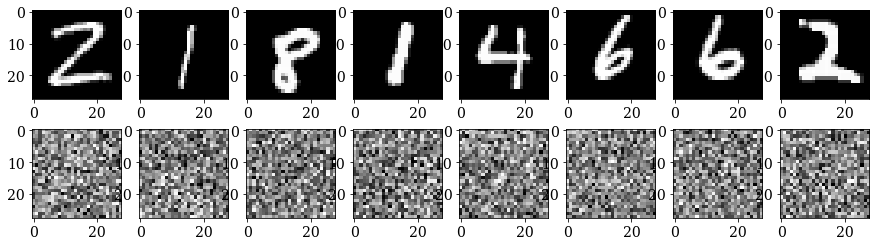

In [4]:
# import the MNIST image database from the Tensorflow package
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# initialize the A matrix values in our model
sess.run(init)
# get a batch of images from the MNIST database
batch_xs, _ = mnist.train.next_batch(batchSize)
#run the model in order to extract the randomly initialized parameter values
initialComponents = sess.run((AT), feed_dict={x: batch_xs})

# plot some observations and some of the initialized basis components (columns of the A matrix)
plt.subplots(figsize=(15, 4))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(batch_xs[i,:].reshape(28, 28),interpolation='none',cmap=plt.get_cmap('gray'))
    plt.subplot(2, 8, i+1+8)
    plt.imshow(initialComponents[:,i].reshape(28, 28),interpolation='none',cmap=plt.get_cmap('gray'))

## 3.3 Paraméterbecslés futtatása és kiértékelése

Hogy megtaláljuk a megfigyeléseinket legjobban magyarázó képkomponenseket, le kell futtatnunk a fent definiált költségfüggvény minimalizálását. Ehhez nem kell mást megadnunk, mint azt, hogy összesen hányszor iteráljunk végig a teljes képadatbázison. Ez a lépés viszonylag sok időt vehet igénybe (a becsült paramétereket elmenthetjük és később visszatölthetjük a Tensorflow segítségével). 

550/550 [==============================] - 2s 3ms/step - avg cost: 4764.2837


550/550 [==============================] - 2s 3ms/step - avg cost: 1579.3134


550/550 [==============================] - 2s 3ms/step - avg cost: 1075.4966


550/550 [==============================] - 2s 3ms/step - avg cost: 869.3235


550/550 [==============================] - 2s 3ms/step - avg cost: 776.2700


550/550 [==============================] - 2s 3ms/step - avg cost: 752.9240


550/550 [==============================] - 2s 3ms/step - avg cost: 748.9555


550/550 [==============================] - 2s 3ms/step - avg cost: 748.2849


550/550 [==============================] - 2s 3ms/step - avg cost: 747.9814


550/550 [==============================] - 2s 3ms/step - avg cost: 748.0998


550/550 [==============================] - 2s 3ms/step - avg cost: 747.9290


550/550 [==============================] - 2s 3ms/step - avg cost: 748.0646


550/550 [==============================] - 2s 3ms/step - avg 

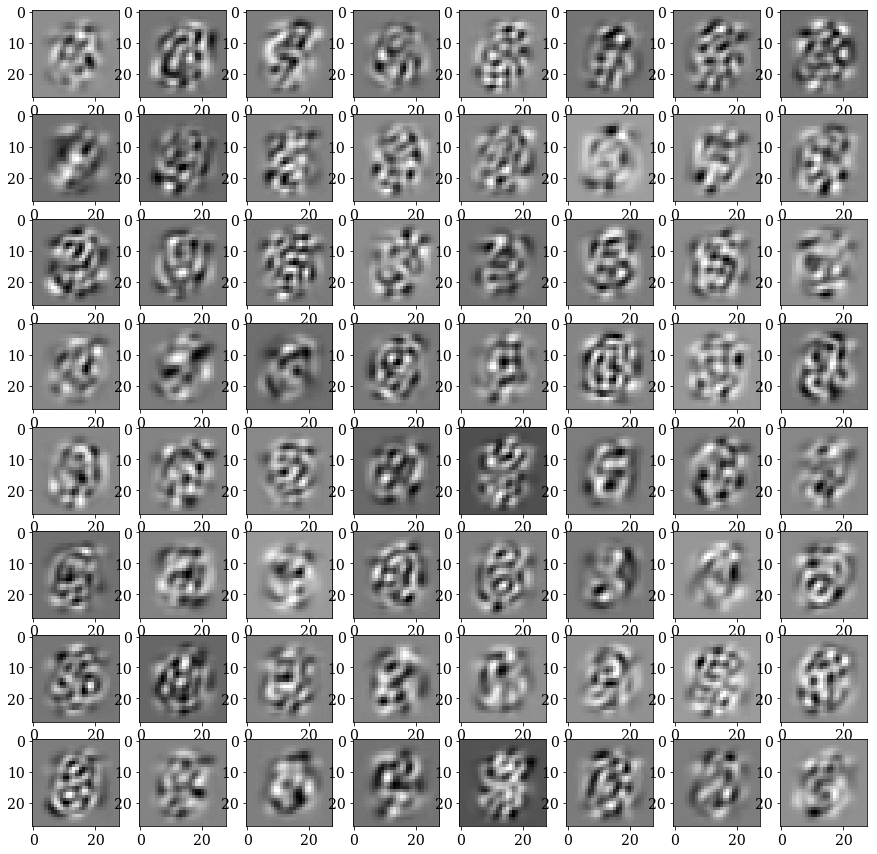

In [5]:
# initialize model parameters
sess.run(init)

runs = 20  # how many iterations do we want to do on the whole database
balanceAct = 0 # we only care about the log-likelihood at this point
nBatches = int(mnist.train.num_examples / batchSize)
for epoch in range(runs):  
    # this is a nice progress bar
    pbar = tf.contrib.keras.utils.Progbar(nBatches)
    for i in range(nBatches):
        # get a new batch from the MNIST database at each step
        batch_xs,_ = mnist.train.next_batch(batchSize)
        # run the model with the optimizer
        _,costValue,learnedComponents = sess.run((optimizer, cost, AT), feed_dict={x: batch_xs, balance: balanceAct * np.ones(1)})
        # update the progress bar
        pbar.add(1,[("avg cost",costValue)])
    print("\n")
print("final cost:",costValue)

# plot all the columns in the learned A matrix, that is the learned image components
plt.subplots(figsize=(15, 15))
for i in range(d_u):
    plt.subplot(8, 8, i+1)
    plt.imshow(learnedComponents[:,i].reshape(28, 28),interpolation='none',cmap=plt.get_cmap('gray'))

## 3.4 A prior szerepe a paraméterbecslésben

Láthatjuk, hogy a fenti paraméterbecslés eredménye sok információt tartalmaz a számjegyek alakjáról, de egyenként nem könnyen értelmezhető alapelemei a képeknek, és az idegsejtek mérhető aktivitásához sem köthetők jól. Ezt úgy tudjuk orvosolni, ha a modellünkbe beépítjük azt az elvárást, hogy minden egyes megfigyelést a lehető legkevesebb komponens összegével magyarázzunk (az idegrendszerben ez például azért jó ötlet, mert így kevesebb, metabolikusan költséges akciós potenciált kell generálnia a neurális populációnk). Ezt az $u$ prior eloszlásának megváltoztatásával tehetjük meg. 

A fenti tulajdonság neve sparseness, az egyik eloszláscsalád ami rendelkezik vele a Laplace, amint azt ábrázolhatjuk azonos szórású, nulla meanű, magasdimenziós Gauss és Laplace eloszlásokból vett mintákon. Egyébként a lineáris-Gauss modell az általunk alkalmazott paramétermegszorításokkal a Gauss prior esetén a Principal Component Analysis (PCA) modellel, a Laplace priorral pedig az Independent Component Analysis (ICA) modell egy változatával ekvivalens.

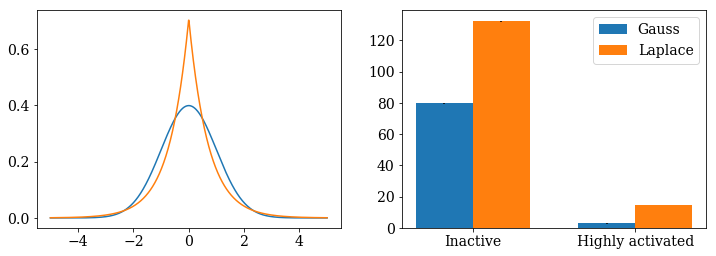

In [83]:
from scipy.stats import multivariate_normal as gauss
from scipy.stats import laplace
from scipy.stats import sem

# generate a bunch of random values from high-dimensional Gauss and Laplace distributions
dim = 1000
nSamp = 1000
random_vals = np.zeros((2,dim,nSamp))
random_vals[0,:,:] = gauss.rvs(size=(dim,nSamp))
random_vals[1,:,:] = laplace.rvs(loc=0, scale=1/np.sqrt(2), size=(dim,nSamp))

# see how many of the dimensions are very active or inactive on average (based on totally arbitrary tresholds)
inactive = np.sum(abs(random_vals) < 0.1, axis=1)
activated = np.sum(abs(random_vals) > 3, axis=1)
# calculate means and standard errors
gauss_mean = [np.mean(inactive,axis=1)[0],np.mean(activated,axis=1)[0]];
laplace_mean = [np.mean(inactive,axis=1)[1],np.mean(activated,axis=1)[1]];
gauss_sem = [sem(inactive,axis=1)[0],sem(activated,axis=1)[0]];
laplace_sem = [sem(inactive,axis=1)[1],sem(activated,axis=1)[1]];

# plot the density functions in one dimension
plt.subplots(figsize=(12, 4))
plt.subplot(1,2,1)
xgrid = np.linspace(-5,5,1000)
plt.plot(xgrid,gauss.pdf(xgrid))
plt.plot(xgrid,laplace.pdf(xgrid,loc=0, scale=1/np.sqrt(2)))

# plot the number of activated and inactive dimensions
plt.subplot(1,2,2)
index = np.arange(2)
bar_width = 0.35
plt.bar(index, gauss_mean, bar_width, yerr=gauss_sem,label='Gauss')
plt.bar(index + bar_width, laplace_mean, bar_width, yerr=laplace_sem,label='Laplace')
plt.xticks(index + bar_width / 2, ('Inactive', 'Highly activated'))
plt.legend()

Megmutatható, hogy a Laplace prior használata az $u$ változón ekvivalens azzal, ha a negatív log-likelihoodot tartalmazó költségfüggvényhez hozzáadjuk az $u$ vektor abszolútértékét (L1-normáját). Ezt már fentebb beépítettük, és a `balance` paraméter állításával aktiválhatjuk. Szóval csak újra kell futtatni az előzővel azonos paraméterbecslési kódot pozitív `balance` értékkel. 

548/550 [============================>.] - ETA: 0s - avg cost: 6986.1611

550/550 [==============================] - 2s - avg cost: 3222.7407     


537/550 [============================>.] - ETA: 0s - avg cost: 2632.8909

537/550 [============================>.] - ETA: 0s - avg cost: 2437.2241

535/550 [============================>.] - ETA: 0s - avg cost: 2360.9795

537/550 [============================>.] - ETA: 0s - avg cost: 2327.0908

537/550 [============================>.] - ETA: 0s - avg cost: 2301.9270

550/550 [==============================] - 2s - avg cost: 2287.6125     


549/550 [============================>.] - ETA: 0s - avg cost: 2282.5896

546/550 [============================>.] - ETA: 0s - avg cost: 2276.3567

535/550 [============================>.] - ETA: 0s - avg cost: 2272.8457

536/550 [============================>.] - ETA: 0s - avg cost: 2269.0349

550/550 [==============================] - 1s - avg cost: 2268.1409     


535/550 [==========================

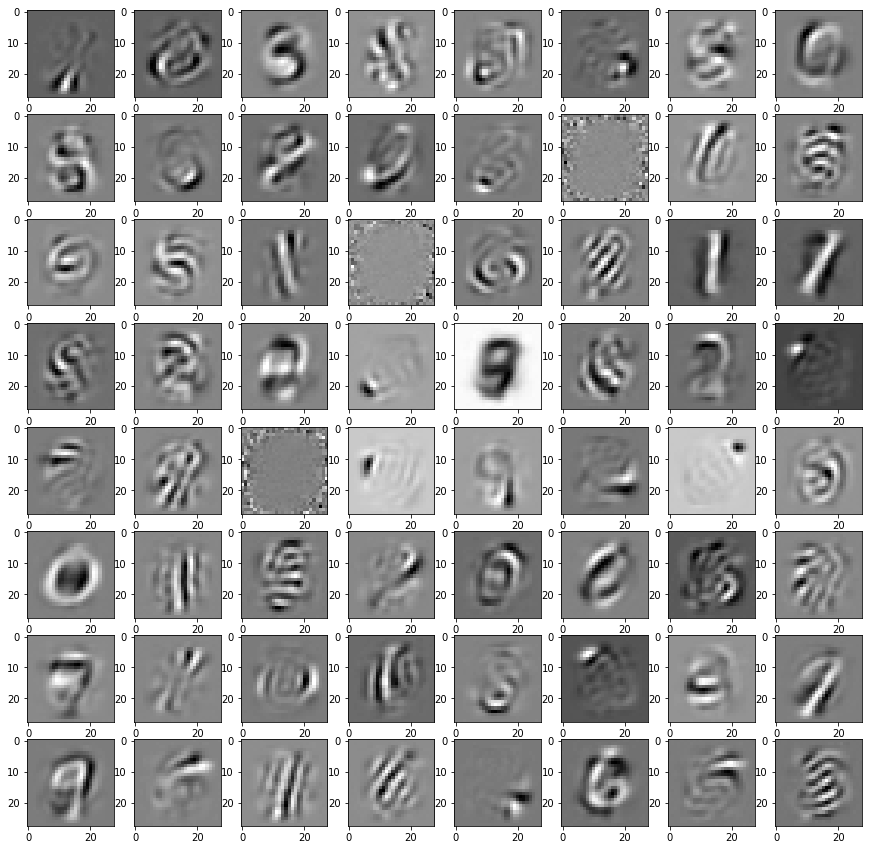

In [32]:
sess.run(init)
runs = 20
balanceAct = 0.4
for epoch in range(runs):    
    pbar = tf.contrib.keras.utils.Progbar(nBatches)
    for i in range(nBatches):
        batch_xs, _ = mnist.train.next_batch(batchSize)
        _,cost_,learnedComponents = sess.run((optimizer, cost, AT), feed_dict={x: batch_xs, balance: balanceAct * np.ones(1)})
        pbar.add(1,[("avg cost",cost_)])
    print("\n")
print("final cost:",cost_)

plt.subplots(figsize=(15, 15))
for i in range(d_u):
    plt.subplot(8, 8, i+1)
    plt.imshow(learnedComponents[:,i].reshape(28, 28),interpolation='none',cmap=plt.get_cmap('gray'))

Láthatjuk, hogy az így kapott báziskomponensek között megjelennek az erősen lokalizált, adott irányú vonásokat reprezentáló képek (bár a természetes képeknél szegényesebb adat és nem túl hosszadalmasan futtatott becslési algoritmus miatt sok komponens elég béna).

Ez az eredmény összevethető az alábbi cikkel, amelyben megállapítják, hogy a sparseness feltételezésével természetes képeken becsült komponensek hasonlatosak az elsődleges látókéregben mért sejtek átlagos válaszintenzitását leíró receptív mezőkhöz:

Olshausen, B. A., & Field, D. J. (1996). [Emergence of simple-cell receptive field properties by learning a sparse code for natural images](http://www.cns.nyu.edu/~tony/vns/readings/olshausen-field-1996.pdf). Nature, 381(6583), 607.